<a href="https://colab.research.google.com/github/FHnt97/TOM_Thesis/blob/main/WLK_%2B_MMH_Debiasing_Classification_Algorithms_1_0_AGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness in Occupational Fatigue Detection
    

# Content

---

Find an introduction to the aim and dataset in the README file.



- **Dataset**
    - MMH & WLK datasets (merged)
    - **Sensitive attribute**: age (in buckets of 10 years) 
    - The dataset has an unqeual sample size for both age and task groups. 

- **Domain**
    - Operations management - fatigue detection 

- **ML task**
    - SVM (rbf)
    - RFC 
    - LinearClassifier - LogisticRegression

- **Fairness tasks**
    - Assessment of unfairness 
    - Mitigation of unfairness with a focus on equal **FALSE NEGATIVE RATE** and **EQAULIZED ODDS**


- **Model performance metrics**:
    - Confusion matrix
    - Recall, accuracy & precision
    - ROC curve

- **Model fairness metrics**:
    - Equalized odds /  False negatives and False negative rate
    - Selection Rate

- **Mitigation algorithms**:

*The objective is to reduce false negatives / make them equal (avoid burnout of employees)*

    - Reweighting (aif360)
    - Exponential gradient (fairlearn - postprocessing)
    - ThresholdOptimizer (fairlearn - postprocessing)



```
# Nomeclature: 

X ∈ Rᵈ: quantified features of the applicant

A ∈ {0, 1}: binary sensitive attribute gnder

C :=c(X,A) ∈ {0,1}: binary predictor (stressed vs. ok), which makes decision based on a score R:=r(x, a) ∈ [0,1]

Y ∈ {0, 1}: target variable

```

    


# Base code
------

Using the work by [Maman et al. (2020)](https://zahrame.github.io/FatigueManagement.github.io/) as a base, we apply a fairness unaware model, namely **SVM (circular kernel), RF and a generic LGM model (logistic regression).** 



### Libraries & helper functions

In [1]:
# importing general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import Markdown, display

In [35]:
# Helper functions metrics
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate, },
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group


def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})

In [2]:
# !pip install model-card-toolkit
!pip install --upgrade fairlearn==0.7.0
!pip install fairml
!pip install aif360

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 18.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fairml: filename=fairml-0.1.1.5rc1-py3-none-any.whl size=8804 sha256=a71e10b989c1219b14addc4f42d3ab8df2563f700c500ac70687009f0cb81362
  Stored in directory: /root/.cache/pip/wheels/6f/44/b7/07613082ee66d893ca0e252d2a5793cd371fcf5107c477234d
Successfully built fairml
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 16.0 MB/s 
     |████████████████████████████████| 569 kB 36.0 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=4f837b2267bbfb2241866da5c92782f0134f80832808e40cd0a73aba644d4ead
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69

### Data load and wrangling

In [3]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# open csv datasets
# if using collab use -->
pathMMH = '/content/drive/MyDrive/00 - thesis/Thesis - Fabia Höhne/Datasets/Fatigue-modeling-master/MMH_15p.csv'
pathWLK = '/content/drive/MyDrive/00 - thesis/Thesis - Fabia Höhne/Datasets/Fatigue-modeling-master//WLK_13p.csv'

# if using the GitHub repo use -->
# pathMMH = './Datasets/Fatigue-modeling-master/MMH_15p.csv'
# pathWLK = './Datasets/Fatigue-modeling-master/WLK_13p.csv'

df_MMH = pd.read_csv(pathMMH, sep=',')
df_WLK = pd.read_csv(pathWLK, sep=',')

In [5]:
# make column names the same for both dfs
df_MMH['fatiguestate'] = df_MMH['fatiguestate1']
df_WLK['fatiguestate'] = df_WLK['Fatigue state']
df_WLK['subject'] = df_WLK['subject'].apply(lambda x: x+'00')

df_MMH.rename(columns = {'age':'Age', 'HRR-Mean': 'HRR.Mean', 'HRR-CV':'HRR.CV'}, inplace = True)
df_MMH.columns = df_MMH.columns.str.replace('coefficient.of.variation', 'CV')

df_MMH = df_MMH.drop(['fatiguestate1'], 1)
df_WLK = df_WLK.drop(['Fatigue state'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


In [6]:
# merge datasets
df = pd.concat([df_MMH, df_WLK])

In [7]:
df = df.dropna(axis='columns')

In [8]:
# delete:
## fatiguestate (already in fatiguestate1); Unnamed (no critical information); gender (only available in one dataset)
df = df.drop(['Unnamed: 0'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df.task.unique()

array(['MMH', 'WLK'], dtype=object)

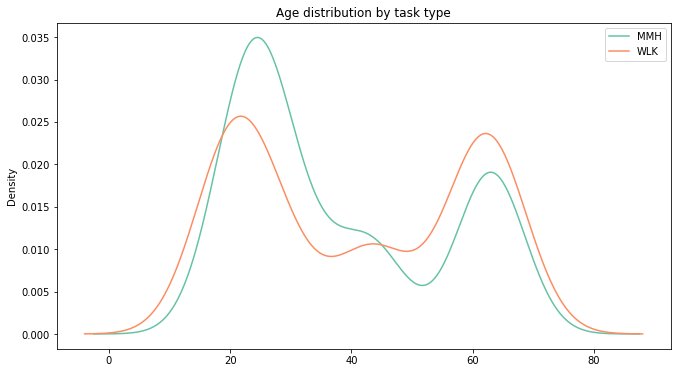

In [10]:
# check gender & age representation 
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(11, 6))
ax.set_title('Age distribution by task type')
df.groupby('task').Age.plot(kind='kde')
ax.legend()


In [11]:
df.Age.mean()

39.27833001988071

In [12]:
# convert subject to numerical values 
df['subject'] = df['subject'].str.replace('P','')

In [13]:
# bin age into groups to noramlize
def custom_round(x, base):
    return base * round(float(x)/10)

df['Age'] = df.Age.apply(lambda x: custom_round(x, 10))

In [14]:
# for this dataset features are NOT normalised, as preprocessing of data has already peen carried out by the owners of the dataset. How this is done is described in detail in their code & paper cited above. 
# in case of wanting to normalise, I would suggest normalising only mean values - variation has already been pre-calculated, and so is the HHR values (% of total possible HR)
# you can use (pandas or sklearn library 'preprocessing.MinMaxScaler'): 
# normalized_df=(df-df.min())/(df.max()-df.min())
# normalized_df=(df-df.mean())/df.std()


'''https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame'''

'https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame'

### Exploratory analysis 

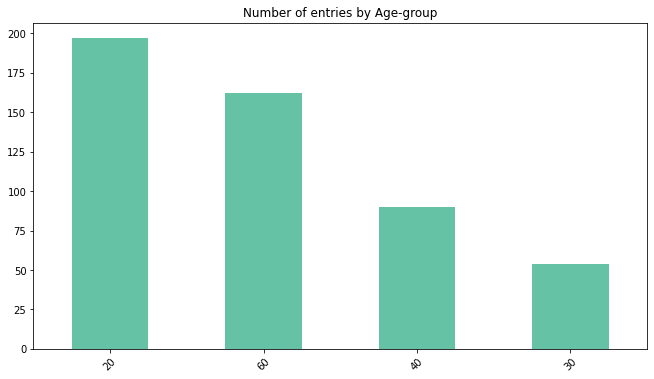

In [15]:
# there are 18 entries per subject
# get distributions 
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(11, 6))
ax.set_title('Number of entries by Age-group')
df["Age"].value_counts().plot(kind='bar', rot=45)

In [16]:
# drop subject as it is not relevant for analysis
df_1 = df.drop(['subject'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


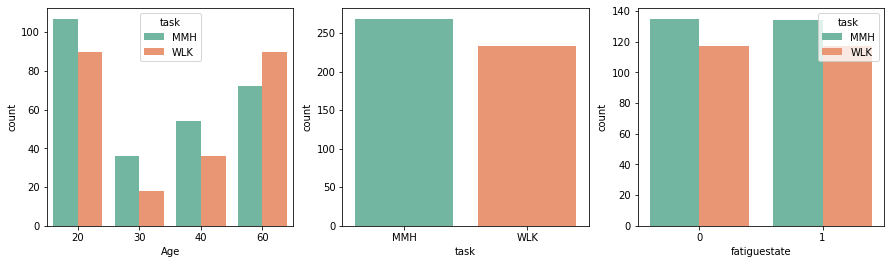

In [17]:
# check sample distributions
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 4)
sns.countplot(df_1['Age'], ax=ax[0], hue=df_1.task)
sns.countplot(df_1['task'], ax=ax[1])
sns.countplot(df_1['fatiguestate'], ax=ax[2], hue=df_1.task)
fig.show()

Task and fatigue state is well distributes in sample; age is not (1 participant has about 18 entries, there are only 2 participants in their 30s)

Pairplots analysis not appropiate with the high number of attributes therefore deleted.


In [18]:
# convert task to numerical values 
df['task'] = df['task'].str.replace('MMH', '1')
df['task'] = df['task'].str.replace('WLK', '2')

In [19]:
# define df with only attriutes that are needed & significant according to correlation analysis below
df.columns
cols = ['subject', 'task', 'Age', 'fatiguestate',  
        'HRR.Mean', 'HRR.CV',
        'Wrist.jerk.Mean', 
        'Ankle.jerk.Mean', 'Ankle.ACC.Mean', 'Ankle.xposture.Mean',
        'number of steps', 'average step time', 'average step distance',
        'time bent', 
        'mean hip osicllation', 'mean foot osicllation', 
        'leg rotational velocity sag plane', 'leg rotational position sag plane', 
        'Wrist.jerk.CV', 'Wrist.ACC.CV',
        'Hip.jerk.CV', 'Hip.ACC.CV', 'Hip.yposture.CV']

cols_rfc = ['subject', 'task', 'Age', 'fatiguestate', 
            'HRR.Mean', 'HRR.CV', 
            'Wrist.jerk.Mean', 'Ankle.xposture.Mean',
            'average step time', 
            'leg rotational velocity sag plane',
            'leg rotational position sag plane',
            'Wrist.jerk.CV', 'Wrist.ACC.CV', 
            'Hip.ACC.CV']

# for cross validation, we get better refults if we don't implement the rfc attributes only 

df = df[cols]

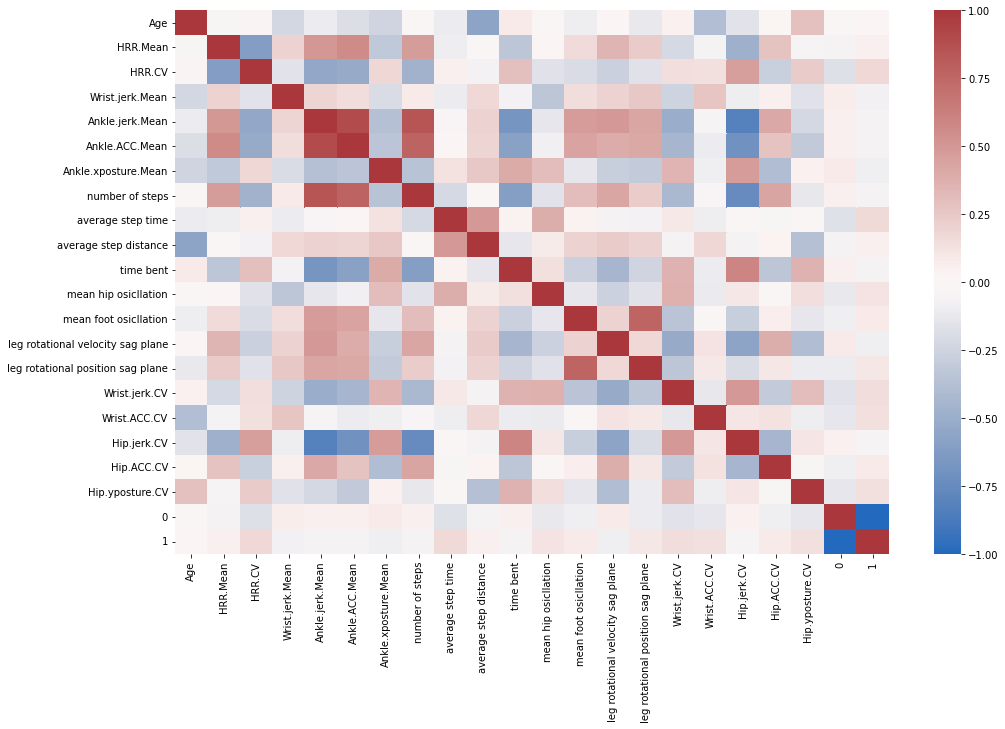

In [ ]:
# correlation analysis 
df_corr = pd.concat([df.drop('fatiguestate', axis=1), pd.get_dummies(df['fatiguestate'])], axis=1)
corr = df_corr.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr,  cmap="vlag")

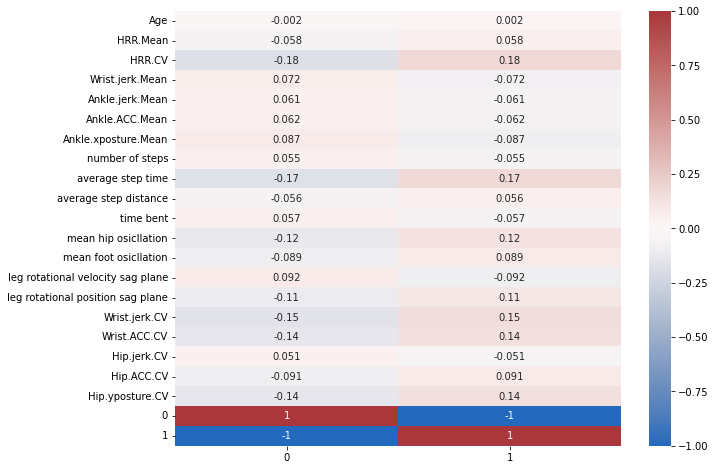

In [20]:
# all features with a corr. under |0.05| are removed
feats = df.columns[1:]

df_corr = pd.concat([df[feats].drop('fatiguestate', axis=1), pd.get_dummies(df[feats]['fatiguestate'])], axis=1)
corr = df_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[[0,1]], annot=True, cmap="vlag")

## Stress Model

---


### Model set-up: libraries & helper functions

In [22]:
# libraries for data processing  
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


# libraries for
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# libraries for feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.utils import Bunch

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold


### Model set-up: test/train split 

In [89]:
# set test & train data & defining age as sensitive attribute
# fairness through unawareness if achieved by additionally dropping task and age
# X = df.drop(columns=['task', 'Age', 'fatiguestate'])
X = df.drop(columns=['fatiguestate'])

y = df['fatiguestate']

A = df[['Age', 'task']]
task_str = A['task'].map({ 1:"MMK", 2:"WLK"})

In [90]:
# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, task_str_train, task_str_test = train_test_split(
    X, 
    y, 
    A, 
    task_str,
    test_size = 0.4, # increse number for more fairness 
    random_state=42)


### Model set-up: defining classifiers

In [25]:
from numpy import random 
# set up model:
classifiers = [RandomForestClassifier(n_estimators = 100, random_state = random.seed(123)),
               LogisticRegression(random_state = 42, solver = 'newton-cg', C=1000000),
               SVC(kernel='rbf', C = 64, gamma = 0.01, class_weight='balanced', probability = True)]

#### RF feature selection - best subset

In [26]:
# feature selection Random Forest
## 1. Best subset selection
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

sel.get_support()

selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat)) # --> provides 10 - in line with previous paper
print(selected_feat)


10
Index(['HRR.Mean', 'HRR.CV', 'Wrist.jerk.Mean', 'Ankle.xposture.Mean',
       'average step time', 'leg rotational velocity sag plane',
       'leg rotational position sag plane', 'Wrist.jerk.CV', 'Wrist.ACC.CV',
       'Hip.ACC.CV'],
      dtype='object')


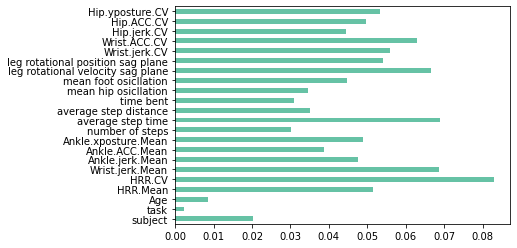

In [27]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

features = list(X)

pd.Series(rfc.feature_importances_, index=features).plot(kind='barh')

# if needed adapt the list of columns used for the generic model

#### log reg feature selection - LASSO

In [28]:
# feature selection using LASSO - based on https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a#:~:text=How%20can%20we%20use%20it,its%20coefficient%20equal%20to%200.
pipeline = Pipeline([('scaler',StandardScaler()),
                     ('model',Lasso())
                     ])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

# run code below to re-fit -- blended out for computational easy of code
'''search.fit(X_train,y_train)
search.best_params_
coefficients = search.best_estimator_.named_steps['model'].coef_'''

# 'model__alpha': 0.2

"search.fit(X_train,y_train)\nsearch.best_params_\ncoefficients = search.best_estimator_.named_steps['model'].coef_"

In [29]:
'''importance = np.abs(coefficients)
np.array(features)[importance > 0]'''

'importance = np.abs(coefficients)\nnp.array(features)[importance > 0]'

#### SVM param. selection

In [ ]:
# run code below to re-fit -- blended out for computational easy of code
'''C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f" 
      % (grid.best_params_, grid.best_score_))
'''

# The best parameters are {'C': 1000.0, 'gamma': 1e-05} with a score of 0.86

## Model evaluation
-----

Classification models are evaluated with:

- Accuracy scores (number of correct predictions divided by the total number of predictions)
- Confusion Matrices (visual representation of ground truth vs. model prediction)
- Precision (Type-I error) & recall (Type-II error) 
- F1 scores (precision/ recall balance score0
- AU-ROC curves - Area under Receiver operating characteristics curve - high ROCs represent a high probability of a random positive sample being positive 

All metrics aim towards 1


Note that:
- H0: participant is stressed
- Type-I error is a false positive, i.e. a true H0 is rejected
- Type-II error is a false negative, i.e. a false H0 is accepted


As we aim to decrease Type-II errors, therefore aim for a higher recall value in the precision-recall tradeoff. 
Imbalanced classes can cause low recall (**sample-bias**) or untuned model parameters. 


### Model evaluation - confusion matrix test & train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

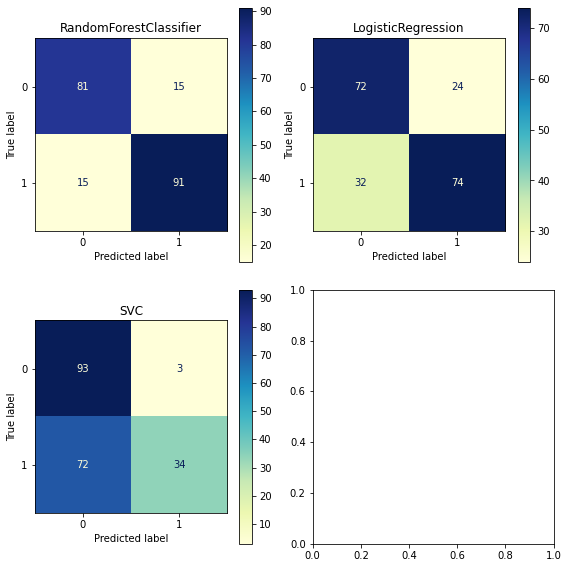

In [30]:
# test set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [ ]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, 
    y_train)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

### Model evaluation - cross validation scores

In [ ]:
# train model, get accuracies and CV
groups = X_test['subject']
gkf = GroupKFold(n_splits=4)

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  scores = cross_val_score(model, X_test, y_test, cv=gkf, groups=groups, scoring='accuracy')
  print (f'{model}  {chr(10)} CV: {scores.mean()} {chr(10)}')

RandomForestClassifier()  
 CV: 0.6288235294117648 

LogisticRegression(C=1000000, random_state=42, solver='newton-cg')  
 CV: 0.6340196078431373 

SVC(C=64, class_weight='balanced', gamma=0.01, probability=True)  
 CV: 0.5298039215686274 



### Model evaluation - classification report (precision, recall, f1, support, accuracy)
> Note: Accuracy, recall & precision are not called for when usign Decision Tree models.

In [32]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f'{model}: {chr(10)} {classification_report(y_test, y_pred)}')

RandomForestClassifier(): 
               precision    recall  f1-score   support

           0       0.90      0.84      0.87        96
           1       0.87      0.92      0.89       106

    accuracy                           0.88       202
   macro avg       0.88      0.88      0.88       202
weighted avg       0.88      0.88      0.88       202

LogisticRegression(C=1000000, random_state=42, solver='newton-cg'): 
               precision    recall  f1-score   support

           0       0.69      0.75      0.72        96
           1       0.76      0.70      0.73       106

    accuracy                           0.72       202
   macro avg       0.72      0.72      0.72       202
weighted avg       0.73      0.72      0.72       202

SVC(C=64, class_weight='balanced', gamma=0.01, probability=True): 
               precision    recall  f1-score   support

           0       0.56      0.97      0.71        96
           1       0.92      0.32      0.48       106

    accuracy    

### Model evaluation - precision/ recall

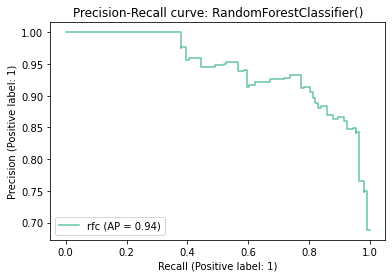

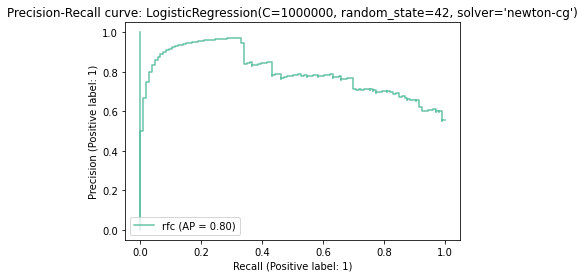

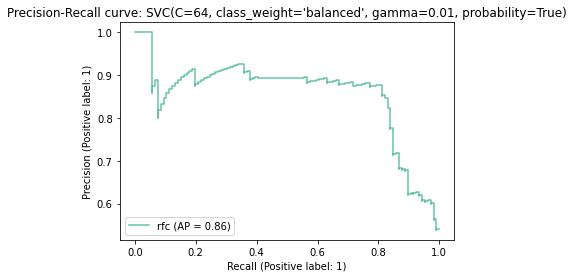

In [33]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')

### Model evaluation - ROC

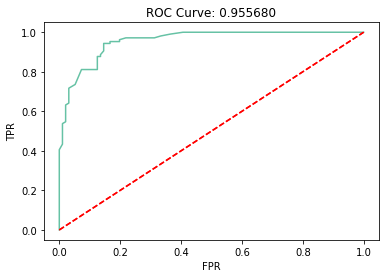

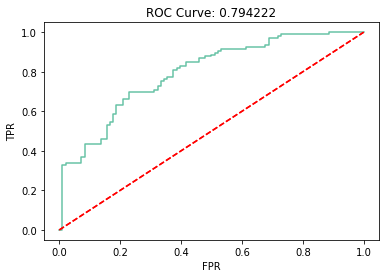

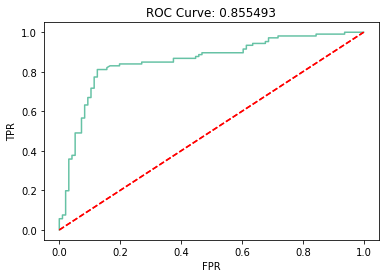

In [34]:
# scores on test set
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred)
  ax = (
      pd.DataFrame(tpr, index=fpr)
      .plot(legend=False, title=('ROC Curve: %f' % auc(fpr, tpr)))
  )
  ax.plot([(0,0), (1,1)], 'r--')
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')

## Fairness Measure

---



We aim to check:
- **Equalised odds** (we want to ensure that the number of false negatives is equally low; we need to reduce false positives which can be costly (variable is not subjective anyways))
- **balance for negative class**
- **dispartities between exact groups**


We aim for group fairness - participants with similar characteristics should be treated similarily.


CONSIDER:
1. disaggregated evaluations - evaluating perfromance with respect to different subgroups (age/ task)



---
<br>

For supervised classification --> output should be the same accross sensitive characterisitcs - bias if the decision changes after beig exposed to additioanl sensitve feature inputs 
<br>


### Install libraries & helper functions

### Fairness evaluation - confusion matrix by group


In [91]:
# define sensitive attributes
#task = A_test['task']
age =  A_test['Age']


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Age:{chr(10)}{model}: {chr(10)} {metric_frame (age)} {chr(10)}')




You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


Age:
RandomForestClassifier(): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.205882  0.027027  0.972973  0.794118
30   0.307692       0.0       1.0  0.692308
40       0.05  0.052632  0.947368      0.95
60   0.103448  0.111111  0.888889  0.896552 

Age:
LogisticRegression(C=1000000, random_state=42, solver='newton-cg'): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.176471  0.351351  0.648649  0.823529
30   0.384615  0.357143  0.642857  0.615385
40        0.6  0.157895  0.842105       0.4
60   0.206897  0.305556  0.694444  0.793103 

Age:
SVC(C=64, class_weight='balanced', gamma=0.01, probability=True): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.647059  0.135135  0.864865  0.352941
30   0.846154  0.142857  0.857143  0.153846
40        0.5  0.052632  0.947368       0.5
60   0.517241  0.083333  0.916667  0.482759 



### Fairness evaluation - fairness metrics by group (equalized odds, demographic parity difference & ratio, false negative rate difference)

In [37]:
# Metrics 
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}')


Age:
RandomForestClassifier(): 
                                Unmitigated
Equalized_odds_difference         0.334615
False negative rate difference    0.157895
Balanced error rate difference    0.089367
 ------                                   
Demographic parity difference     0.267806
  ------                                  
Overall AUC                       0.953715
AUC difference                    0.073171 

Age:
LogisticRegression(C=1000000, random_state=42, solver='newton-cg'): 
                                Unmitigated
Equalized_odds_difference         0.423529
False negative rate difference    0.199248
Balanced error rate difference    0.122721
 ------                                   
Demographic parity difference     0.295414
  ------                                  
Overall AUC                       0.794222
AUC difference                    0.171174 

Age:
SVC(C=64, class_weight='balanced', gamma=0.01, probability=True): 
                                Unmitigate

##### helper function for visualisation


In [95]:
# demographic disparity
# https://github.com/fairlearn/fairlearn/blob/main/notebooks/Mitigating%20Disparities%20in%20Ranking%20from%20Binary%20Data.ipynb

from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 4 ### change to 4/2 depending on the sensitive attribute (Age vs. task)
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

#### Visualisation - performance metric by groups (age)


---



In [96]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1


  display(HTML('<span id="disparity_unmitigated">'))
  plot_and_compare_cdfs(y_pred, task)
  display(HTML('</span>'))

AssertionError: ignored

# Debiasing the model

---


In this part, we aim to mitigate bias (removing the problematic signal) through the addition of inclusion (add signal for desired features for a re-weighted signal to improve fairness)

The dataset is not balanced for any of the groups present (different sample numbers) 


#### Reminder to types of fairness and how to approach them

- Demographic parity applies different classification thresholds per group while keeping the same fraction of +ives
- Equal opp. uses different classification thresholds per group while keeping the same true positive rate
- Equalized odds use different classification thresholds per group while keeping the same true positive&false rate


**We aim for equalized odds (EO) and ERP (error rate parity) cross groups.**


#### De-biasing methods overview:

 - pre-processing: reweighing, disparate impact remover

 - in-process: adversarial debiasing, prejudice remover

- post process-process: through reductions: Exponential gradient (for disparity mitigation), Gridsearch,  ThresholdOptimizer, equalized odds/ calibrated offd/ reject option classification


> NOTE: fairlearn only supports binary classification 



STEPS:
1. Pre-processing 
    - reweigh sample 
    - balance performance metric (already the case equal number of stressed/non-stressed people

2. in process 
    - adversarial debiasing

3. post-process 
    - threshold optimizer, equalized odds






#### import libraries and helper functions

In [97]:
import aif360

from aif360.datasets import StandardDataset
from sklearn.pipeline import make_pipeline 

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover

# fairlearn libraries
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

from fairlearn.reductions import (ExponentiatedGradient, 
                                  EqualizedOdds, 
                                  ErrorRateParity)


In [98]:
# define for the metric frame
metrics = {
    'accuracy': accuracy_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count,
    'balanced error rate': balanced_accuracy_score}

#### 1. Reweigh samples for age (AIF360)

Based on:
1. [Correcting Unfair Binary Classification
Models](http://arno.uvt.nl/show.cgi?fid=157880)

2. [AIF360 example](https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb)


In [99]:
# set dataset in aif360 format
ds_aif = aif360.datasets.StandardDataset (df, 
                                         label_name="fatiguestate",
                                         favorable_classes = [1], 
                                         protected_attribute_names=['Age'], 
                                         privileged_classes= [lambda x: x >= 39],
                                         features_to_drop=['subject'])

In [100]:
# test, train split
ds_train, ds_test = ds_aif.split([0.67], shuffle=True)

In [101]:
# pre-processing - reweighing 
# define priviledged & unpriviledged groups
unpriv = [{'Age': 0}]
priv = [{'Age': 1}]

# reweigh
RW = Reweighing (unprivileged_groups = unpriv, 
                 privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

In [102]:
# check for metric before and after transforming 
# OG dataset
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

# transformed dataset
metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)

In [103]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()

##### Evaluations

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


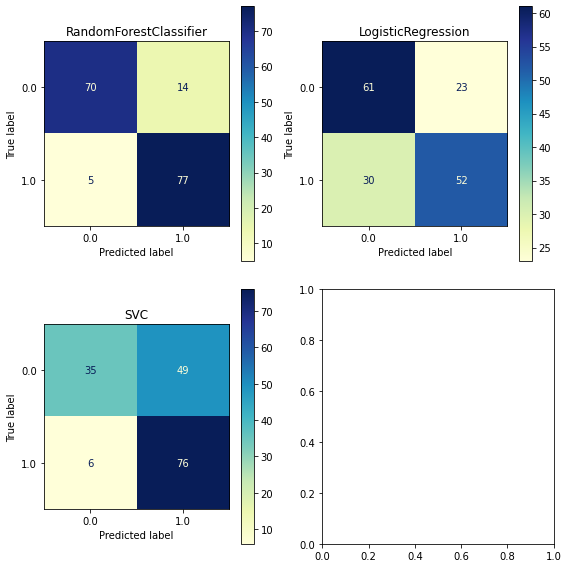

In [104]:
# confusion matrix

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    # train models with reweighted data
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    
    # plot
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)

plt.tight_layout()
plt.show()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


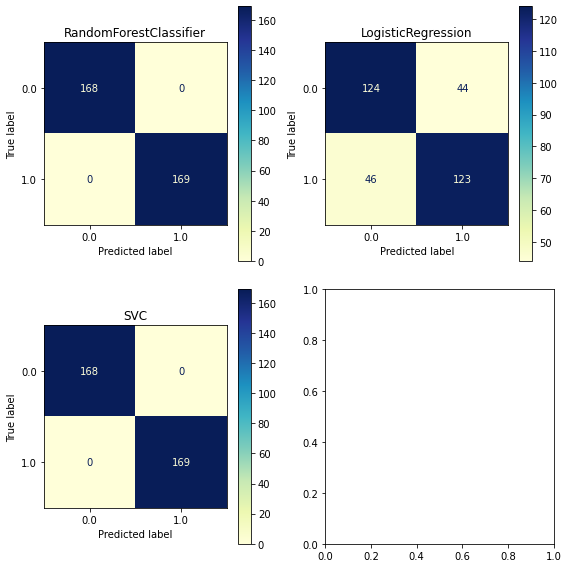

In [105]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [106]:
# get classification reports
for cls in classifiers:
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  print(f'{cls}: {chr(10)} {classification_report(y_test, y_pred)}')

RandomForestClassifier(): 
               precision    recall  f1-score   support

         0.0       0.92      0.83      0.88        84
         1.0       0.84      0.93      0.88        82

    accuracy                           0.88       166
   macro avg       0.88      0.88      0.88       166
weighted avg       0.88      0.88      0.88       166

LogisticRegression(C=1000000, random_state=42, solver='newton-cg'): 
               precision    recall  f1-score   support

         0.0       0.67      0.73      0.70        84
         1.0       0.69      0.63      0.66        82

    accuracy                           0.68       166
   macro avg       0.68      0.68      0.68       166
weighted avg       0.68      0.68      0.68       166

SVC(C=64, class_weight='balanced', gamma=0.01, probability=True): 
               precision    recall  f1-score   support

         0.0       0.85      0.42      0.56        84
         1.0       0.61      0.93      0.73        82

    accuracy    

##### Fairness evaluations

In [107]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

In [111]:
for cls in classifiers:
  dataset = RW_train
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = instance_weights)
  y_pred = cls.predict(X_test)
  
  # scores on test set
  ds_test_pred.scores = cls.predict_proba(X_test)[:1]

  # predictions (0 or 1) on test set
  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f'Gender:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}') # change age<> gender
  print(f'Gender:{chr(10)}{cls}: {chr(10)} {metric_frame (age)} {chr(10)}') # change age<> gender


  mf1 = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=y_pred,
                    sensitive_features=age)

# The disaggregated metrics are stored in a pandas Series mf1.by_group:
  print(f"{cls}:\n {mf1.by_group}\n")
  print(f"{cls} difference:\n {mf1.difference(method='between_groups')}\n")

ValueError: ignored

#### 2. Adverserial debiasing (AIF360)
Not used for report - needs to be further analyzed for the correct use/integration 

In [112]:
metric_orig_train = BinaryLabelDatasetMetric(ds_train, 
                                            unprivileged_groups = unpriv,
                                            privileged_groups = priv)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(ds_test, 
                                            unprivileged_groups = unpriv,
                                            privileged_groups = priv)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.062346
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.120261


In [ ]:
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
import tensorflow.compat.v1 as tf

tf.disable_eager_execution()

sess = tf.Session()
sess.close()

tf.reset_default_graph()
sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = priv,
                                                   unprivileged_groups = unpriv,
                                                   scope_name = 'plain_classifier',
                                                   debias = True,
                                                   sess=sess)

debiased_model.fit(ds_train)

In [ ]:
# Apply the plain model to test data
ds_debiasing_train = debiased_model.predict(ds_train)
ds_debiasing_test = debiased_model.predict(ds_test)

In [ ]:
# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(ds_debiasing_train, 
                                                          privileged_groups = priv,
                                                          unprivileged_groups = unpriv,)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(ds_debiasing_test, 
                                                         privileged_groups = priv,
                                                         unprivileged_groups = unpriv,)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



https://nbviewer.org/github/Trusted-AI/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb#3.-Training-models-on-original-2015-Panel-19-data

### Fair learn - post processign methods



In [113]:
# set test & train data & defining age as sensitive attribute
X = df.drop(columns=['Age', 'task', 'fatiguestate'])
y = df['fatiguestate']

A = df[['Age']]


# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    X, 
    y, 
    A, 
    task_str,
    test_size = 0.33, # increse number for more fairness 
    random_state=42)


#### 3. ExponentiatedGradient - reduction (fair learn)


---


In [ ]:
# train exponentialgradient for each classifier
# get metrics resuts

for cls in classifiers:
  expgrad_est = ExponentiatedGradient(estimator=cls,
                                    constraints=ErrorRateParity(difference_bound=0.01)) # for FNR 1-TPR
  
  expgrad_est.fit(X_train, y_train, sensitive_features=A_train)
  
  y_pred_reductions = expgrad_est.predict(X_test)
  
  
  mf_eg =  MetricFrame(metrics=metrics,
                                       y_true=y_test,
                                       y_pred=y_pred_reductions,
                                       sensitive_features=A_test
                                       )
  
  df_results = pd.concat([mf_eg.by_group],
                          keys=['ExponentiatedGradient'],
                          axis=1)
  
  print (f'{cls}:{chr(10)} {df_results}{chr(10)}')
  print(f"{cls} difference:\n {mf_eg.difference(method='between_groups')}\n")


  # visualize mitigated
  mf_eg.by_group.plot(
      kind="bar",
  #    ylim=[0, 1],
      subplots=True,
      layout=[3, 3],
      legend=False,
      figsize=[12, 8],
      title=f'Show all metrics WESAD - exponentiated gradiant - {cls}',
  )



  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred_reductions >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f':{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') # change age<> gender

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Seri

#### 4. Thresholdoptimizer (fair learn - post processing)

ThresholdOptimizer takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate thrceshold for each group in order to optimize some specified objective metric (such as balanced accuracy) subject to specified fairness constraints (such as false negative rate parity). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

In [ ]:
# fit thesholdoptimizer for each classifier and return mitigated resutls
for cls in classifiers: 
    unmitigated_pipeline = Pipeline(steps=[("model", cls)])

    unmitigated_pipeline.fit(X_train, y_train)
    
    postprocess_est = ThresholdOptimizer(estimator=unmitigated_pipeline,
                                        constraints="equalized_odds",
                                        objective="balanced_accuracy_score",
                                        prefit=True,
                                        predict_method='predict_proba')
    
    postprocess_est.fit(X_train, y_train, sensitive_features=A_train) # change a test in train/ test sample

    y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test) 

    mf_to = MetricFrame(metrics=metrics,
                                          y_true=y_test,
                                          y_pred=y_pred_postprocess,
                                          sensitive_features=A_test) 
    
    df_results = pd.concat([mf_to.by_group],
                            keys=['ThresholdOptimizer'],
                            axis=1)

    print (f'{cls}:{chr(10)} {df_results}{chr(10)}')

    print(f"{cls} difference:\n {mf_to.difference(method='between_groups')}\n")
    
    y_train_pred = cls.predict(X_train)
    test_preds = (y_pred_postprocess >= np.mean(y_train)) * 1

    models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

    print(f':{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') 

    # visualize mitigated
    mf_to.by_group.plot(
        kind="bar",
    #    ylim=[0, 1],
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title=f'Show all metrics WESAD - thresholdoptimizer - {cls}',
    )